## Sibur Challenge 2020
### Прогноз состава сырья
https://sibur.ai-community.com/competitions/4/rules
<br>
Оценивалась наименьшая ошибка (MAPE)<br>
Публичный результат — 2.4284<br>
Приватный результат — 3.6117<br>

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import time as t
import xgboost as xg 
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Загрузка данных

In [2]:
df_train_features=pd.read_csv('data/train_features.csv')
df_train_targets=pd.read_csv('data/train_targets.csv')

In [3]:
def mape_score(y_test, y_pr):
    '''
    Вычисление mape
    '''
    mape=np.array([y_test, y_pr])
    s=np.diff(mape,axis=0)
    s=np.abs(s)
    mape=np.divide(s, y_test)
    return mape.sum()/len(y_test)

In [4]:
def get_index_empty_intervals(df, columns=[]):
    '''
    Получаем интервалы с Nan в колонках
    :param df: df по которому будем считать пустые индексы 
    :param columns: список колонок, которые будем проверять. Если пусто, проверим все колонки
    :return dict_empty: dictionary = {'column_name':[list of indexes]}
    '''
    dict_empty={}
    # if columns are not set, use all columns
    if not columns:
        columns=df.columns
    for column in columns:
        index_empty=df.index[df.loc[:,column].isna()==True].to_list()
        ind=[]
        for key, number in enumerate(index_empty):
            if key==0:
                start=number
            elif number != index_empty[key-1]+1:
                start=number
            if key==len(index_empty)-1:
                end=number
                ind.append([start, end])
            elif number != index_empty[key+1]-1:
                end=number
                ind.append([start, end])
        dict_empty[column]=ind
    return dict_empty

In [5]:
df_train_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921
...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575


In [6]:
df_train_targets

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510
...,...,...,...,...,...
5803,2020-04-30 21:30:00,4.816865,35.539156,16.269938,24.770377
5804,2020-04-30 22:00:00,4.993286,36.067750,16.317757,24.729847
5805,2020-04-30 22:30:00,5.101574,36.275040,16.295460,24.629889
5806,2020-04-30 23:00:00,5.210675,36.872917,16.336359,24.438236


<AxesSubplot:>

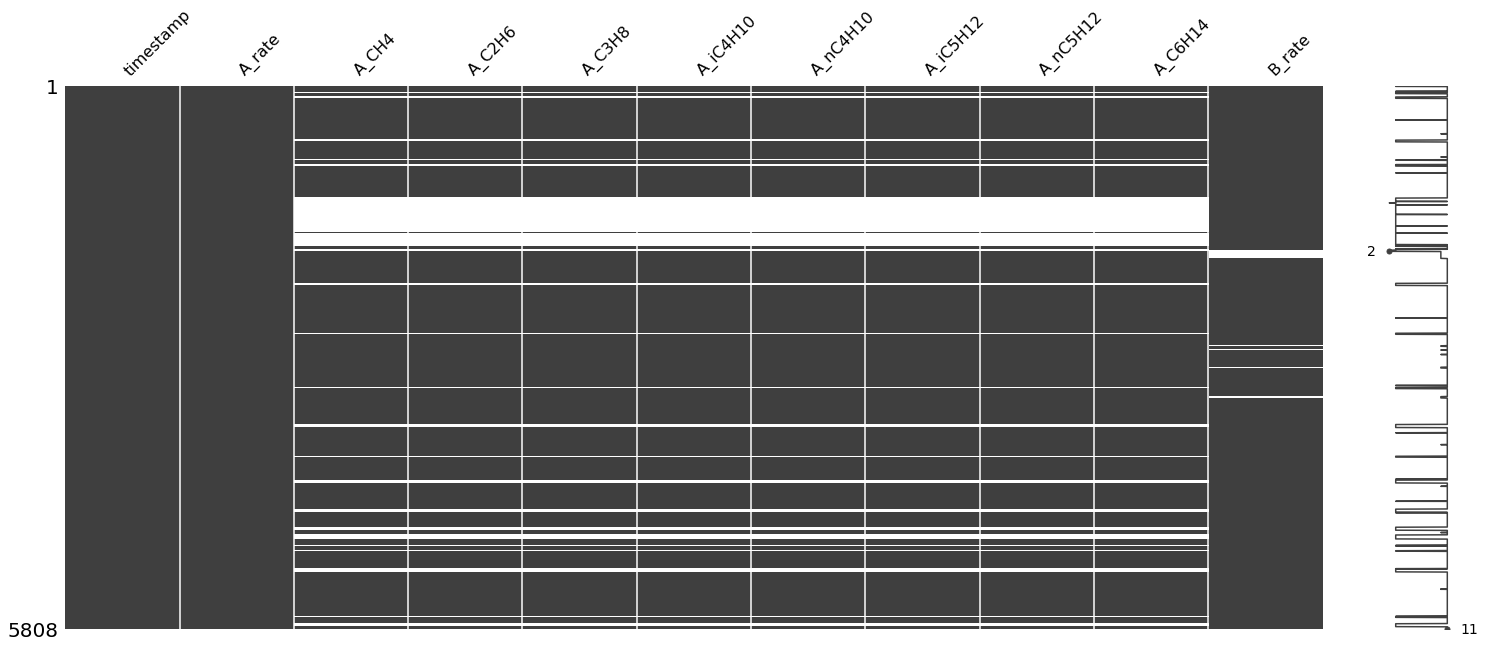

In [7]:
msno.matrix(df_train_features)

<AxesSubplot:>

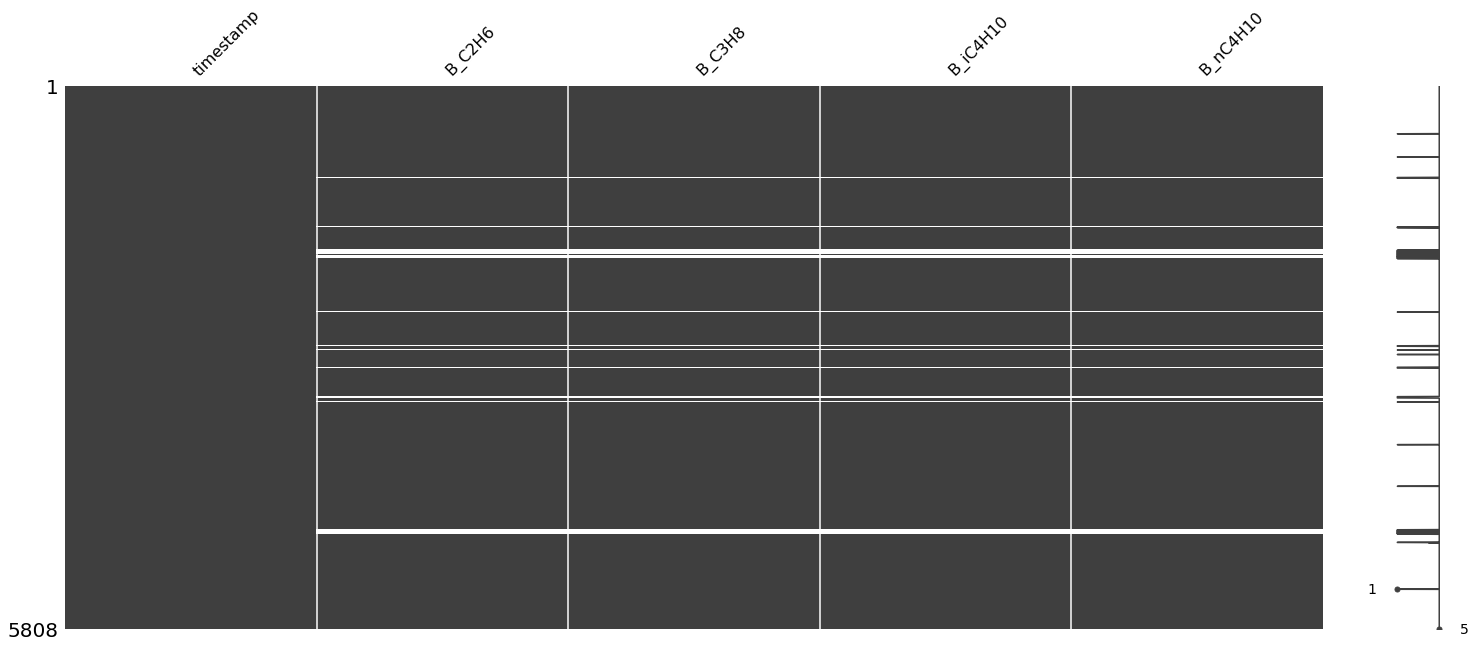

In [8]:
msno.matrix(df_train_targets)

In [9]:
df_combined=df_train_features.merge(df_train_targets, on='timestamp', how='left')

In [10]:
df_combined.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10'],
      dtype='object')

In [11]:
df_combined

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921,4.607483,38.817579,17.108668,24.049510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355,4.816865,35.539156,16.269938,24.770377
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066,4.993286,36.067750,16.317757,24.729847
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367,5.101574,36.275040,16.295460,24.629889
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575,5.210675,36.872917,16.336359,24.438236


<AxesSubplot:>

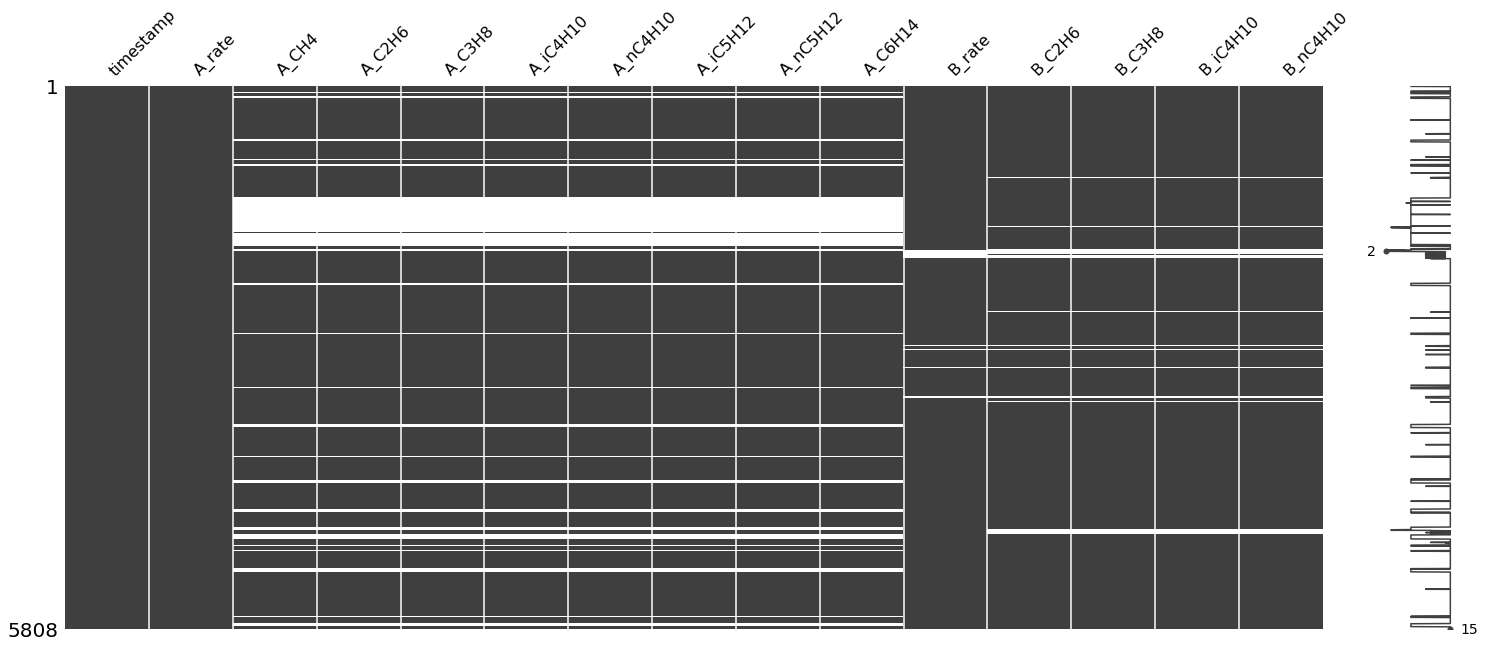

In [12]:
msno.matrix(df_combined)

In [13]:
df_combined['total_out_share']=df_combined['B_C2H6']+df_combined['B_C2H6']+df_combined['B_iC4H10']+df_combined['B_nC4H10']

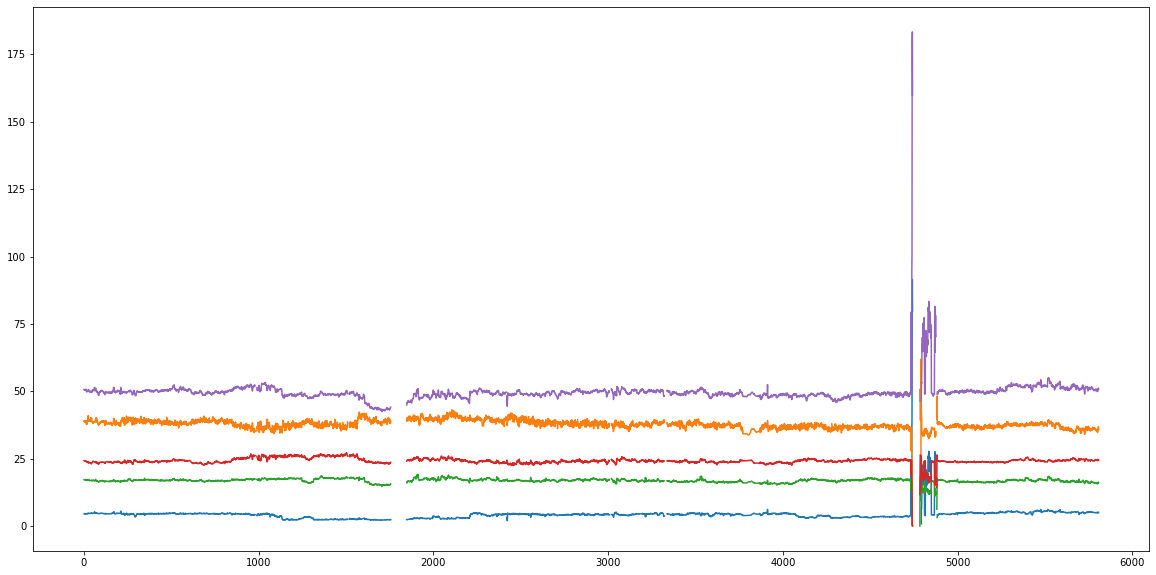

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs.plot(df_combined['B_C2H6'])
axs.plot(df_combined['B_C3H8'])
axs.plot(df_combined['B_iC4H10'])
axs.plot(df_combined['B_nC4H10'])
axs.plot(df_combined['total_out_share'])

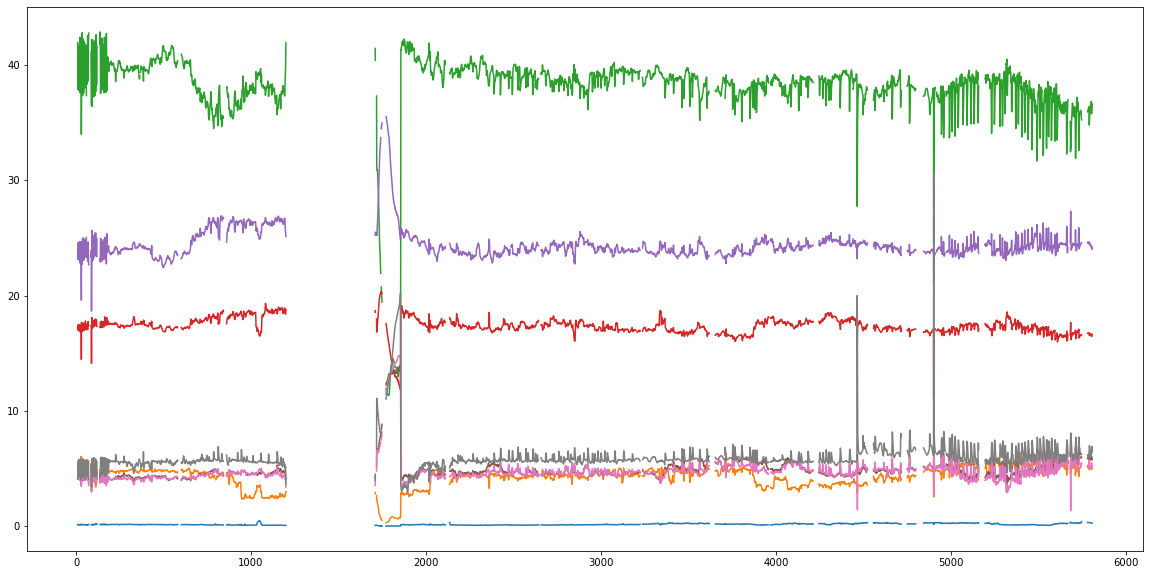

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs.plot(df_combined['A_CH4'])
axs.plot(df_combined['A_C2H6'])
axs.plot(df_combined['A_C3H8'])
axs.plot(df_combined['A_iC4H10'])
axs.plot(df_combined['A_nC4H10'])
axs.plot(df_combined['A_iC5H12'])
axs.plot(df_combined['A_nC5H12'])
axs.plot(df_combined['A_C6H14'])

In [16]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5808 entries, 0 to 5807
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        5808 non-null   object 
 1   A_rate           5807 non-null   float64
 2   A_CH4            4849 non-null   float64
 3   A_C2H6           4849 non-null   float64
 4   A_C3H8           4849 non-null   float64
 5   A_iC4H10         4849 non-null   float64
 6   A_nC4H10         4849 non-null   float64
 7   A_iC5H12         4849 non-null   float64
 8   A_nC5H12         4849 non-null   float64
 9   A_C6H14          4849 non-null   float64
 10  B_rate           5675 non-null   float64
 11  B_C2H6           5624 non-null   float64
 12  B_C3H8           5628 non-null   float64
 13  B_iC4H10         5628 non-null   float64
 14  B_nC4H10         5628 non-null   float64
 15  total_out_share  5624 non-null   float64
dtypes: float64(15), object(1)
memory usage: 771.4+ KB


In [17]:
df_combined.describe()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,total_out_share
count,5807.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,4849.000000,5675.000000,5624.000000,5628.000000,5628.000000,5628.000000,5624.000000
mean,59.346948,0.159890,4.290739,37.990406,17.343168,24.413897,4.948636,4.809805,5.995740,64.817202,4.363701,37.742757,16.843028,24.171264,49.744615
std,20.684895,0.068488,0.912565,3.756424,0.754301,1.274795,1.230539,1.285549,1.543956,10.696414,2.931240,2.218569,1.059827,1.480740,4.365023
min,0.000321,0.008045,0.280524,11.345740,11.143152,18.655932,3.033678,1.338103,2.924722,0.000000,0.861025,0.026142,0.012764,0.019941,27.555511
25%,61.846908,0.109331,3.971011,37.647968,17.018272,23.746663,4.462670,4.353103,5.574106,63.852030,3.503610,36.827096,16.548084,23.736470,48.704103
50%,67.010148,0.139924,4.485758,38.618187,17.327200,24.138643,4.684908,4.619459,5.708216,68.583359,4.395271,37.750088,16.934576,24.147675,49.497421
75%,69.734038,0.212163,4.844390,39.402360,17.685803,24.615843,5.086816,4.925770,6.032535,71.171153,4.680156,38.730979,17.292647,24.642044,50.287813
max,74.560399,0.471429,6.418897,42.860283,20.353500,35.498867,13.812560,14.845480,30.656385,89.958390,91.573613,61.931856,19.235807,27.184879,183.373117


Итого, можно скзать, что данные неравномерны. Отсутствуют данные между X и y в разных временных диапазонах. Куча выбросов

Нужно понять сдвиг от входа к выходу. Потому что прогнозировать мы будем не y(X), а y-сдвинутое от X

In [18]:
i=0
score=[]
gases=['_C2H6','_C3H8', '_iC4H10', '_nC4H10']

In [19]:
for g in gases:
    i=0
    while i < 2500:
        temp_b=df_combined.loc[i:,'B'+g].reset_index(drop=True)
        temp_b=temp_b.fillna(temp_b.notna().mean())
        temp_a=df_combined.loc[:5807-i,'A'+g].reset_index(drop=True)
        temp_a=temp_a.fillna(temp_a.notna().mean())
        score.append([i,mean_squared_error(temp_b.to_list(), temp_a.to_list()), 'mean_squared_error', g])
        i+=1
    i=0
    while i < 2500:
        temp_b=df_combined.loc[i:,'B'+g].reset_index(drop=True)
        temp_b=temp_b.fillna(temp_b.notna().mean())
        temp_a=df_combined.loc[:5807-i,'A'+g].reset_index(drop=True)
        temp_a=temp_a.fillna(temp_a.notna().mean())
        score.append([i,mean_absolute_error(temp_b.to_list(), temp_a.to_list()), 'mean_absolute_error', g])
        i+=1

In [20]:
df_score = pd.DataFrame(score)
df_score.columns=['i','score','metrics', 'element']
df_score=df_score.sort_values(by=['score']).reset_index(drop=True)

In [21]:
df_score_g=df_score[['score','metrics','element']].groupby(['metrics','element']).agg('min').reset_index()

In [22]:
df_score_g=df_score_g.merge(df_score, on =['score','metrics','element'], how='left')

In [23]:
df_score_g

,metrics,element,score,i
0,mean_absolute_error,_C2H6,0.911287,195
1,mean_absolute_error,_C3H8,7.335089,217
2,mean_absolute_error,_iC4H10,3.030493,217
3,mean_absolute_error,_nC4H10,4.168073,217
4,mean_squared_error,_C2H6,9.357830,161
5,mean_squared_error,_C3H8,230.178070,217
6,mean_squared_error,_iC4H10,40.718007,217
7,mean_squared_error,_nC4H10,87.950214,217


Сдвиг 217 временных промежутков выход от входа

In [24]:
i=1100
k=i+217

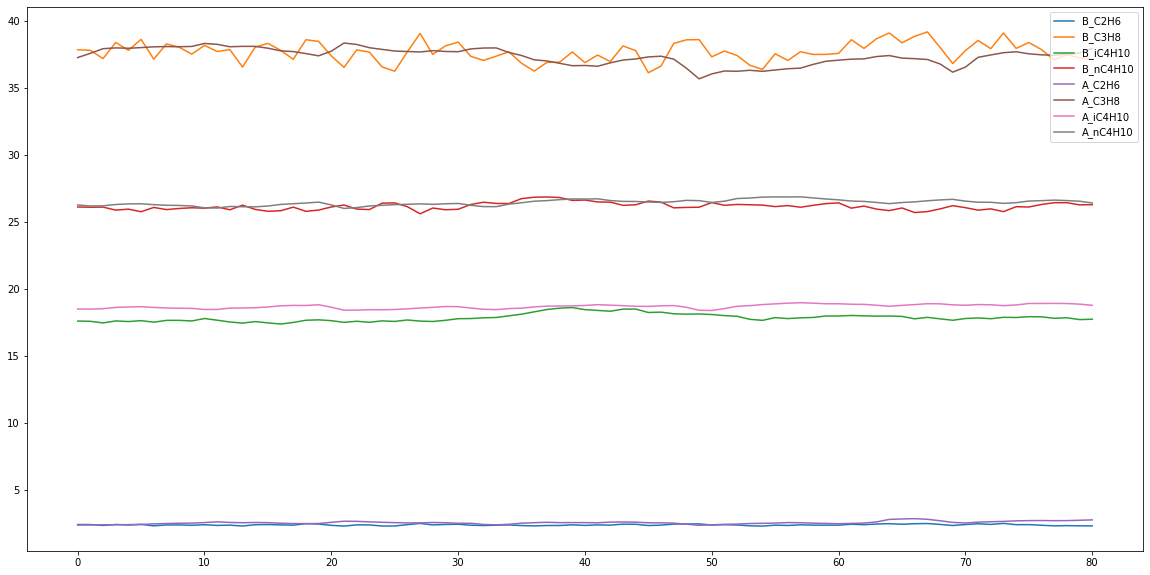

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs.plot(df_combined.loc[k:k+80,'B_C2H6'].reset_index(drop=True), label='B_C2H6')
axs.plot(df_combined.loc[k:k+80,'B_C3H8'].reset_index(drop=True), label='B_C3H8')
axs.plot(df_combined.loc[k:k+80,'B_iC4H10'].reset_index(drop=True), label='B_iC4H10')
axs.plot(df_combined.loc[k:k+80,'B_nC4H10'].reset_index(drop=True), label='B_nC4H10')
axs.plot(df_combined.loc[i:i+80,'A_C2H6'].reset_index(drop=True), label='A_C2H6')
axs.plot(df_combined.loc[i:i+80,'A_C3H8'].reset_index(drop=True), label='A_C3H8')
axs.plot(df_combined.loc[i:i+80,'A_iC4H10'].reset_index(drop=True), label='A_iC4H10')
axs.plot(df_combined.loc[i:i+80,'A_nC4H10'].reset_index(drop=True), label='A_nC4H10')
axs.legend()
i+=50
k=i+265
t.sleep(1)

In [26]:
i

1150

Посмотрим на корелляцию не сдвинутую

<AxesSubplot:>

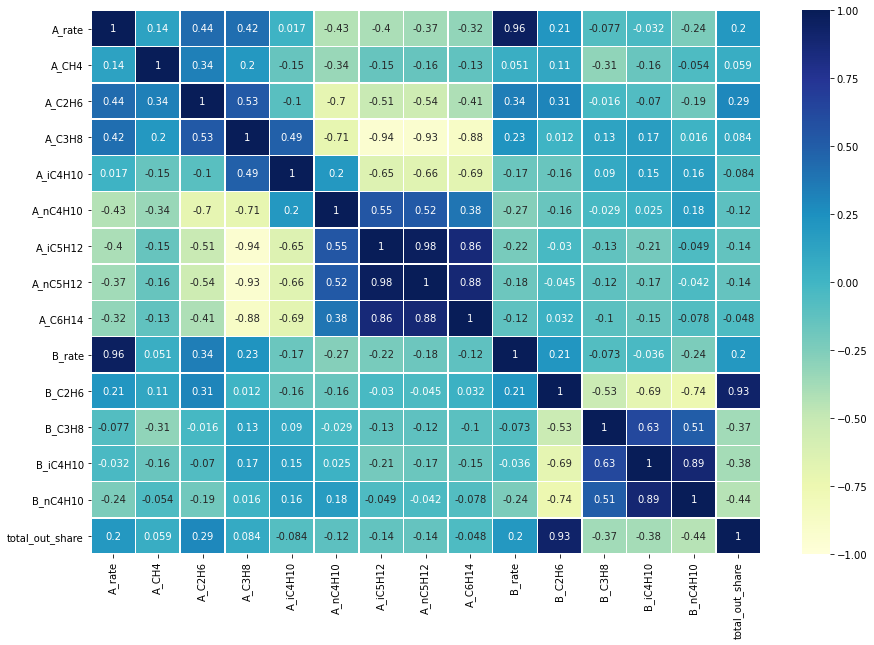

In [27]:
corrMatrix = df_combined.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, vmin=-1, vmax=1, center= 0, cmap="YlGnBu")


In [28]:
df_combined_shifted=df_combined.copy()

In [29]:
df_combined_shifted[['A_C2H6']] = df_combined_shifted[['A_C2H6']].shift(217)


In [30]:
df_combined_shifted[['A_CH4', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14']] = df_combined_shifted[['A_CH4', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14']].shift(217)

In [31]:
df_combined_shifted[210:230]

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,total_out_share
210,2020-01-05 09:00:00,71.675340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.846048,5.577147,38.058265,16.780151,23.513440,51.447885
211,2020-01-05 09:30:00,71.606303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.170288,4.862124,38.290475,16.498749,23.511492,49.734489
212,2020-01-05 10:00:00,71.647661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.192946,4.816158,39.124153,16.735163,23.556766,49.924245
213,2020-01-05 10:30:00,71.703737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.113601,4.646027,38.444793,16.643733,23.656166,49.591954
214,2020-01-05 11:00:00,71.713953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.349543,4.753153,38.609186,16.633472,23.551063,49.690841
215,2020-01-05 11:30:00,71.719857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.295224,4.677904,39.501997,16.643663,23.336662,49.336134
216,2020-01-05 12:00:00,71.745903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.347132,4.558685,38.774874,16.606082,23.523495,49.246947
217,2020-01-05 12:30:00,71.715582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.366448,4.662919,40.086811,16.664116,23.233368,49.223321
218,2020-01-05 13:00:00,71.718371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.288906,4.548945,39.676303,16.868508,23.680821,49.647218
219,2020-01-05 13:30:00,71.717793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.328234,4.592960,40.144988,16.828104,23.481633,49.495657


Посмотрим на корелляцию сдвинутую. Выглядит лучше, чем не сдвинутая

<AxesSubplot:>

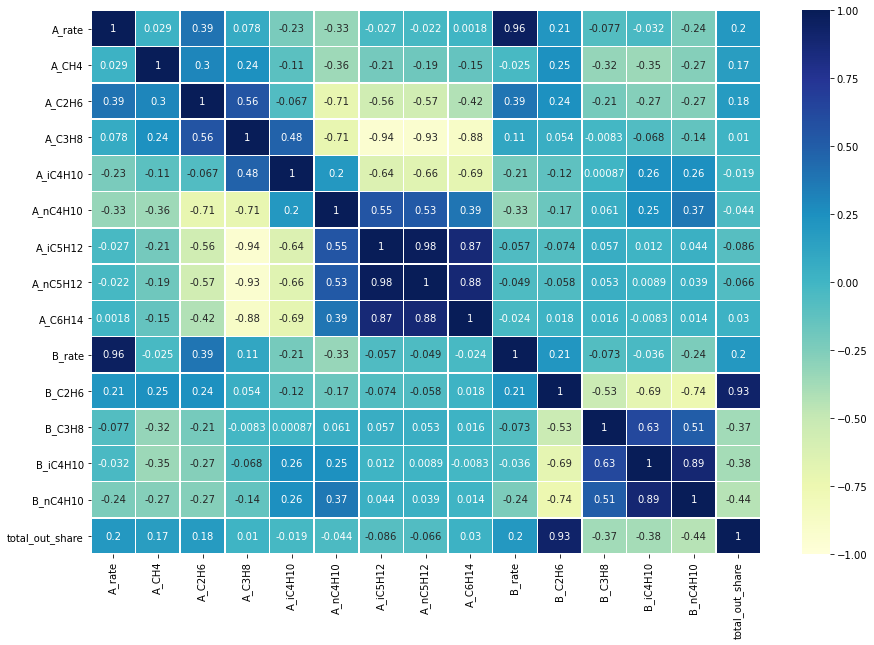

In [32]:
corrMatrix = df_combined_shifted.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, vmin=-1, vmax=1, center= 0, cmap="YlGnBu")

In [33]:
df_combined_shifted=df_combined_shifted.dropna()

<AxesSubplot:>

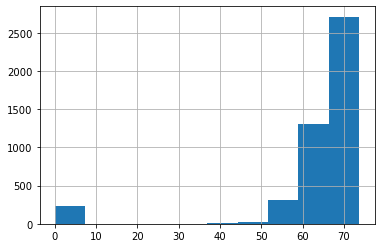

In [34]:
df_combined_shifted['A_rate'].hist()

In [35]:
df_combined_shifted['A_rate'][df_combined_shifted['A_rate']<10]

1198    0.001294
1199    0.001701
1200    0.001525
1201    0.001055
1202    0.001306
          ...   
4632    0.001920
4633    0.001256
4634    0.774746
5202    0.002014
5203    0.001633
Name: A_rate, Length: 237, dtype: float64

<AxesSubplot:>

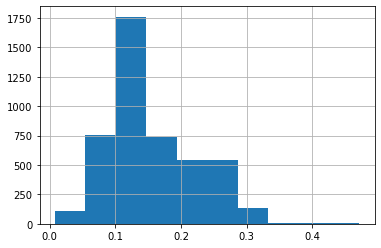

In [36]:
df_combined_shifted['A_CH4'].hist()

In [37]:
df_combined_shifted['A_CH4'][df_combined_shifted['A_CH4']>0.4]

1258    0.402243
1259    0.435752
1260    0.436991
1261    0.437579
1262    0.432692
1263    0.430886
1264    0.454405
1265    0.471429
1266    0.463936
1267    0.446665
1268    0.438359
1269    0.426387
1270    0.404252
Name: A_CH4, dtype: float64

<AxesSubplot:>

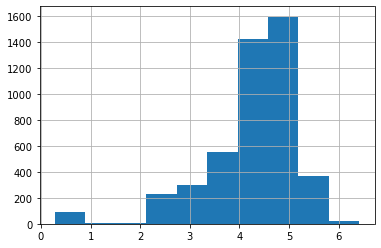

In [38]:
df_combined_shifted['A_C2H6'].hist()

<AxesSubplot:>

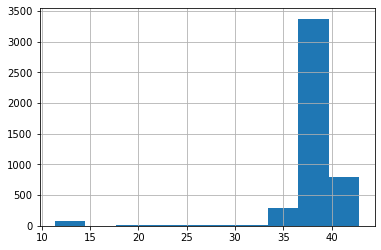

In [39]:
df_combined_shifted['A_C3H8'].hist()

<AxesSubplot:>

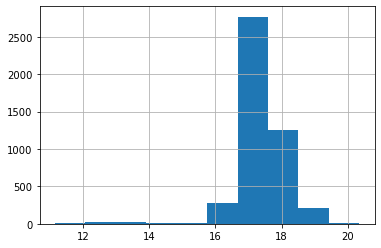

In [40]:
df_combined_shifted['A_iC4H10'].hist()

<AxesSubplot:>

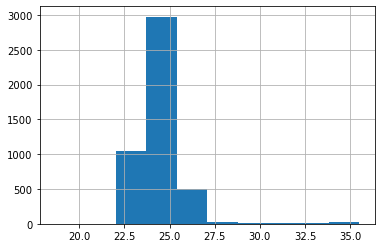

In [41]:
df_combined_shifted['A_nC4H10'].hist()

<AxesSubplot:>

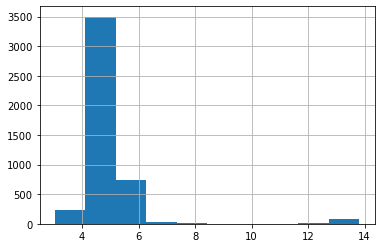

In [42]:
df_combined_shifted['A_iC5H12'].hist()

<AxesSubplot:>

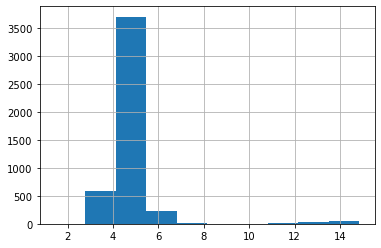

In [43]:
df_combined_shifted['A_nC5H12'].hist()

<AxesSubplot:>

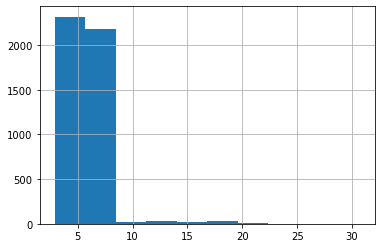

In [44]:
df_combined_shifted['A_C6H14'].hist()

<AxesSubplot:>

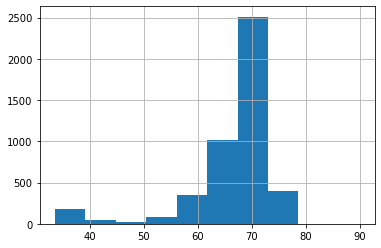

In [45]:
df_combined_shifted['B_rate'].hist()

<AxesSubplot:>

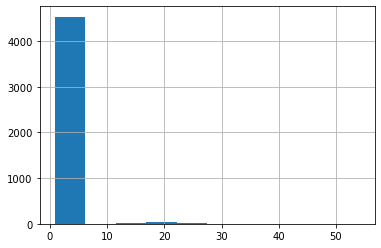

In [46]:
df_combined_shifted['B_C2H6'].hist()

<AxesSubplot:>

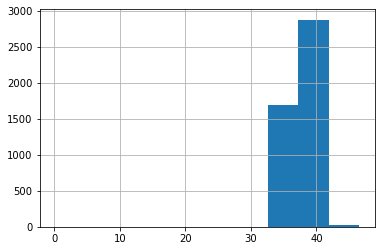

In [47]:
df_combined_shifted['B_C3H8'].hist()

<AxesSubplot:>

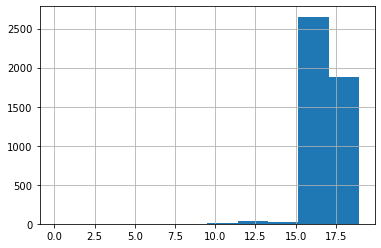

In [48]:
df_combined_shifted['B_iC4H10'].hist()

<AxesSubplot:>

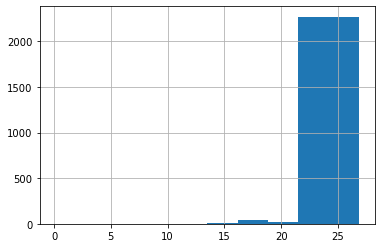

In [49]:
df_combined_shifted['B_nC4H10'].hist()

In [50]:
df_combined_shifted.tail()

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,total_out_share
5803,2020-04-30 21:30:00,72.009730,0.159056,5.409297,37.491332,16.960608,24.376190,5.132600,4.575827,5.849142,74.183355,4.816865,35.539156,16.269938,24.770377,50.674046
5804,2020-04-30 22:00:00,71.854180,0.163466,5.422132,37.179333,16.886633,24.352903,5.191147,4.668147,6.090267,74.213066,4.993286,36.067750,16.317757,24.729847,51.034176
5805,2020-04-30 22:30:00,71.783273,0.171688,5.576616,37.893190,16.925760,24.255477,5.073736,4.469106,5.587223,74.144367,5.101574,36.275040,16.295460,24.629889,51.128497
5806,2020-04-30 23:00:00,71.717743,0.175617,5.544316,37.525045,16.839480,24.215215,5.176123,4.628717,5.849012,74.320575,5.210675,36.872917,16.336359,24.438236,51.195945
5807,2020-04-30 23:30:00,71.730325,0.183288,5.623656,37.996517,16.891180,24.129747,5.078052,4.478657,5.572187,74.327170,5.136487,35.860326,16.101509,24.426845,50.801327


<AxesSubplot:>

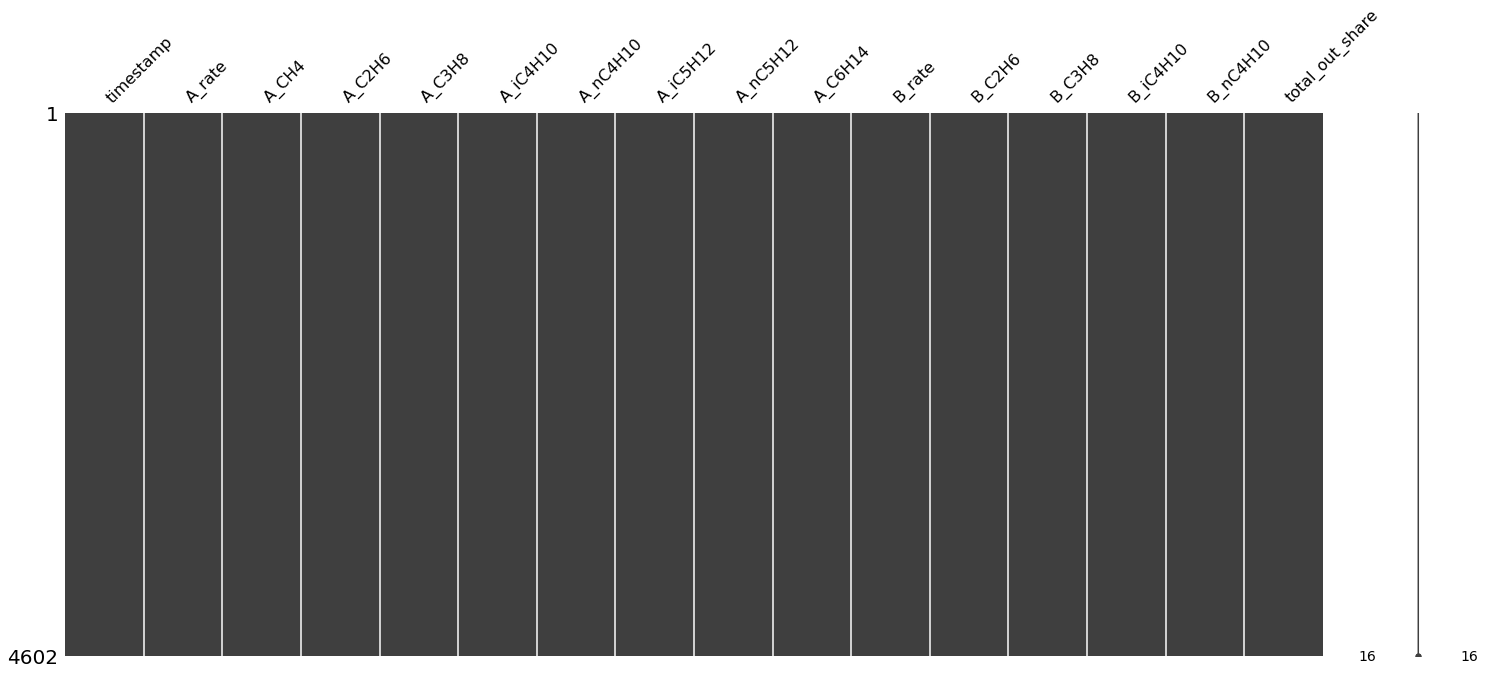

In [51]:
msno.matrix(df_combined_shifted)

Начинаем править выбросы

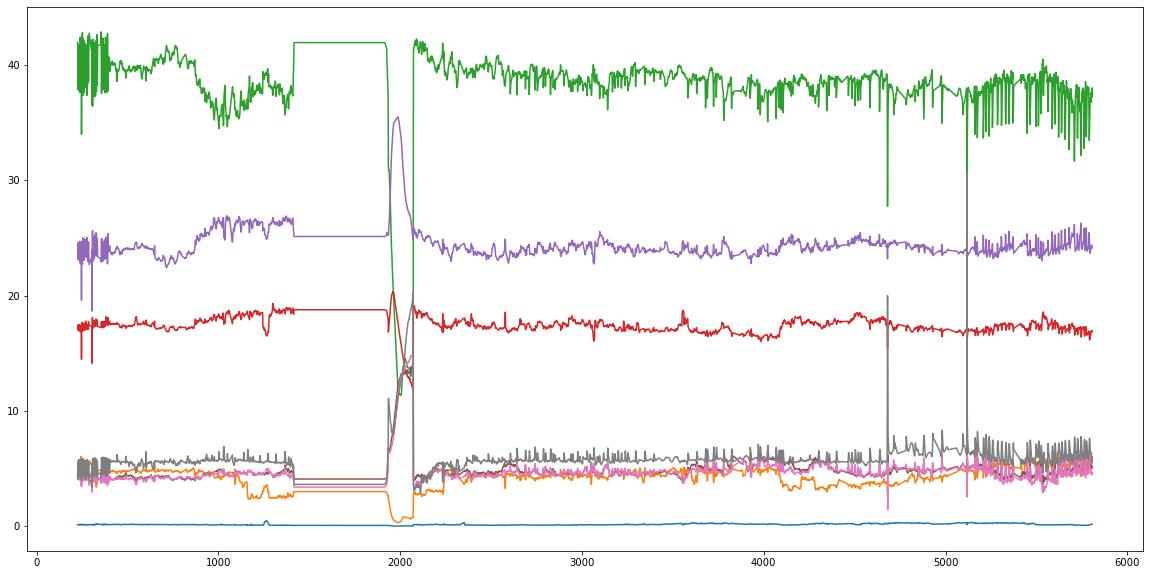

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs.plot(df_combined_shifted['A_CH4'])
axs.plot(df_combined_shifted['A_C2H6'])
axs.plot(df_combined_shifted['A_C3H8'])
axs.plot(df_combined_shifted['A_iC4H10'])
axs.plot(df_combined_shifted['A_nC4H10'])
axs.plot(df_combined_shifted['A_iC5H12'])
axs.plot(df_combined_shifted['A_nC5H12'])
axs.plot(df_combined_shifted['A_C6H14'])

<AxesSubplot:>

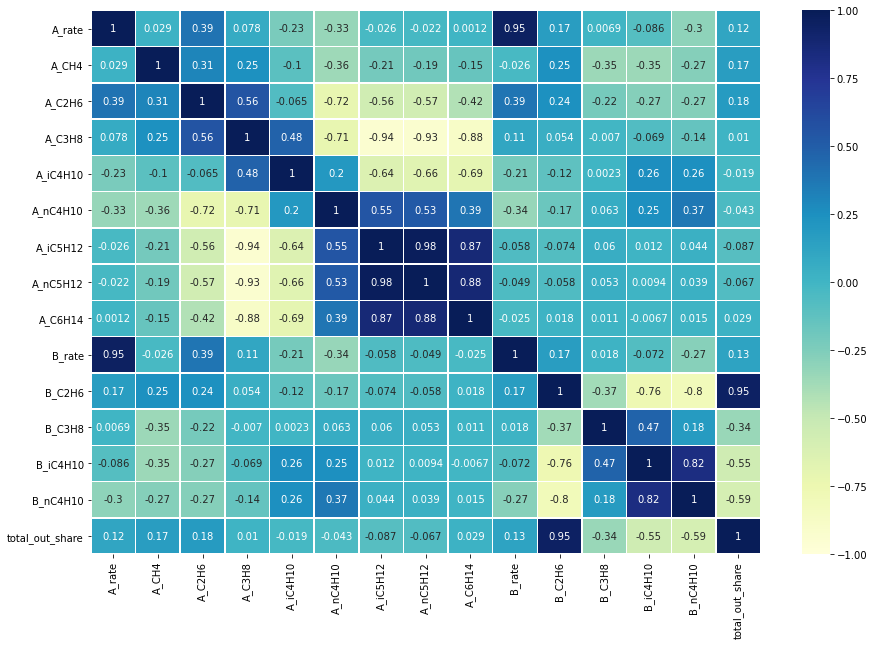

In [53]:
corrMatrix = df_combined_shifted.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, vmin=-1, vmax=1, center= 0, cmap="YlGnBu")

In [54]:
from sklearn.ensemble import IsolationForest

In [55]:
clf = IsolationForest(random_state=0).fit(df_combined_shifted[['A_iC4H10']])
d=clf.predict(df_combined_shifted[['A_iC4H10']])

In [56]:
d

array([1, 1, 1, ..., 1, 1, 1])

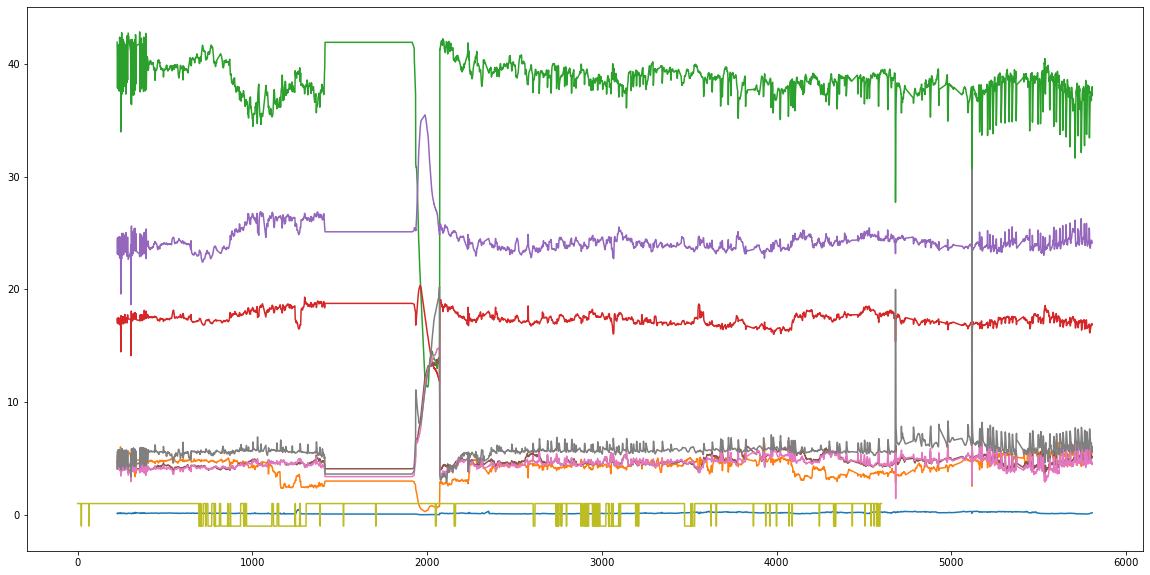

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
axs.plot(df_combined_shifted['A_CH4'])
axs.plot(df_combined_shifted['A_C2H6'])
axs.plot(df_combined_shifted['A_C3H8'])
axs.plot(df_combined_shifted['A_iC4H10'])
axs.plot(df_combined_shifted['A_nC4H10'])
axs.plot(df_combined_shifted['A_iC5H12'])
axs.plot(df_combined_shifted['A_nC5H12'])
axs.plot(df_combined_shifted['A_C6H14'])
axs.plot(d)

In [58]:
df_combined_shifted.describe()

,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,total_out_share
count,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000,4602.000000
mean,63.127934,0.156017,4.256582,38.058813,17.372065,24.416374,4.917091,4.792250,5.983176,66.569365,4.459411,37.691784,16.881804,24.181799,49.982426
std,15.372649,0.066355,0.918132,3.823702,0.756682,1.301708,1.245741,1.310712,1.577512,8.118556,2.347781,1.598562,0.818751,1.149944,3.321409
min,0.000350,0.008045,0.280524,11.345740,11.143152,18.655932,3.033678,1.441303,2.924722,33.520214,0.861025,0.099073,0.039690,0.074563,27.555511
25%,63.870265,0.108436,3.897642,37.752146,17.051917,23.735839,4.453436,4.336401,5.565542,65.359859,3.760454,36.762956,16.581533,23.764986,48.803383
50%,67.389978,0.137508,4.467791,38.677806,17.350963,24.123784,4.661805,4.600974,5.695319,68.785434,4.426651,37.649574,16.949016,24.177730,49.591453
75%,69.696210,0.201047,4.817690,39.424686,17.710160,24.630276,5.017520,4.877748,5.994849,71.124195,4.692381,38.593483,17.277800,24.624735,50.422386
max,73.719648,0.471429,6.418897,42.860283,20.353500,35.498867,13.812560,14.845480,30.656385,89.958390,54.095680,46.527746,18.949716,26.869981,108.311995


In [59]:
df_combined_shifted['A_CH4'][(df_combined_shifted['A_CH4']>=(0.155504-0.065479*3)) &
                             (df_combined_shifted['A_CH4']<=(0.155504+0.065479*3))].count()

4585

In [60]:
def out_zscore(data):
    global outliers,zscore
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return print("Total number of outliers are",len(outliers))

In [61]:
for c in ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10']:
    out_zscore(df_combined_shifted[c])

Total number of outliers are 237
Total number of outliers are 17
Total number of outliers are 104
Total number of outliers are 101
Total number of outliers are 77
Total number of outliers are 64
Total number of outliers are 87
Total number of outliers are 85
Total number of outliers are 93
Total number of outliers are 221
Total number of outliers are 64
Total number of outliers are 14
Total number of outliers are 64
Total number of outliers are 65


D:\ProgramData\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


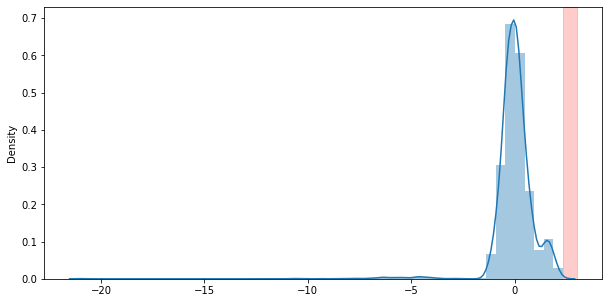

In [62]:
plt.figure(figsize = (10,5))
sns.distplot(zscore)
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red')

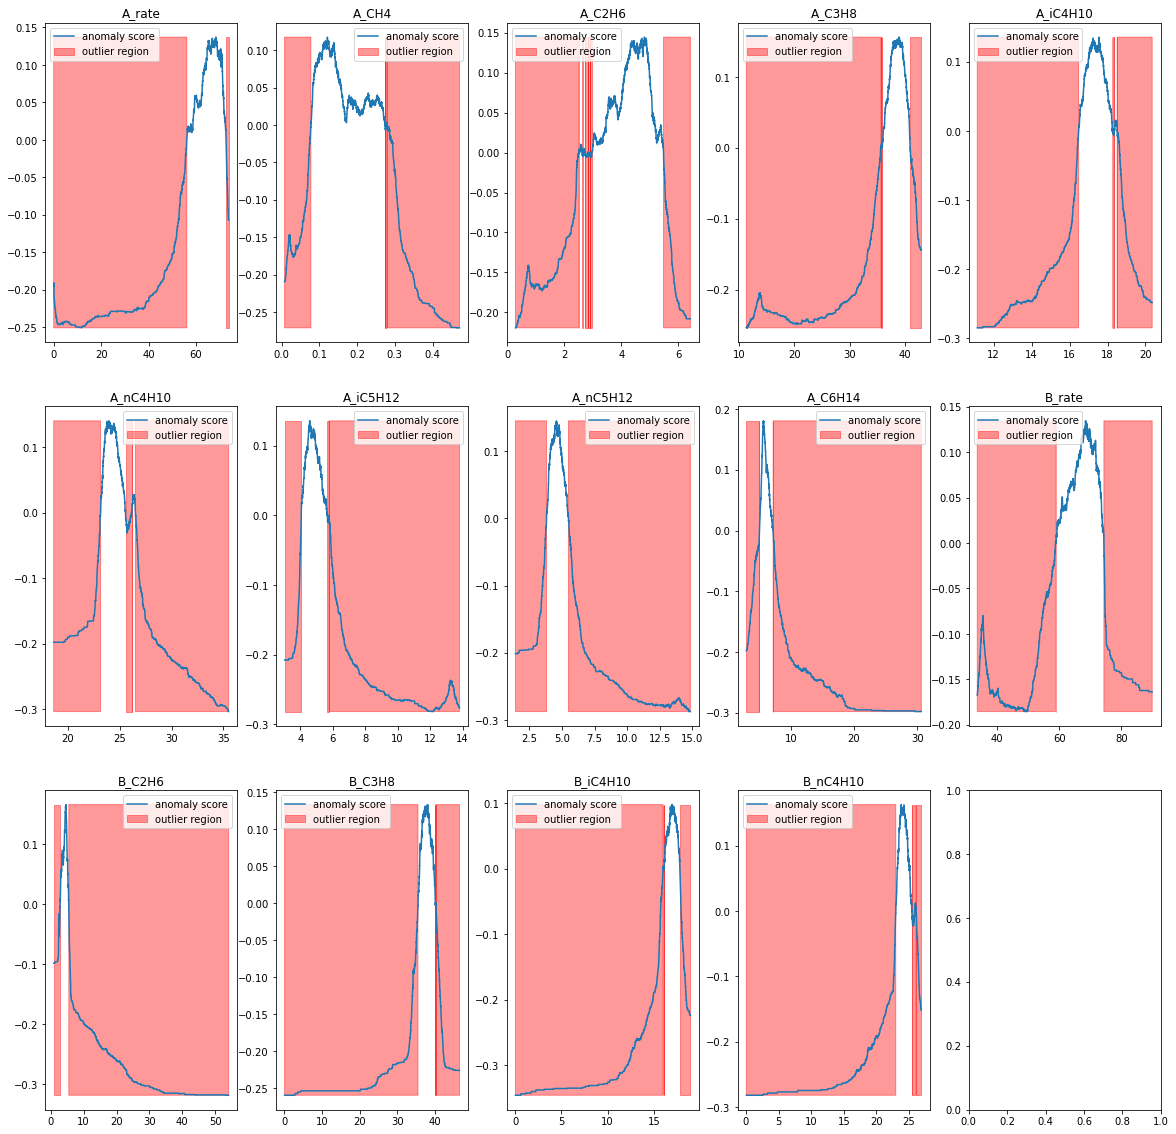

In [63]:
cols = ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10']
#Plotting the sub plot
fig, axs = plt.subplots(3, 5, figsize=(20, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1)
    isolation_forest.fit(df_combined_shifted[column].values.reshape(-1,1))

    xx = np.linspace(df_combined_shifted[column].min(), df_combined_shifted[column].max(), len(df_combined_shifted)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

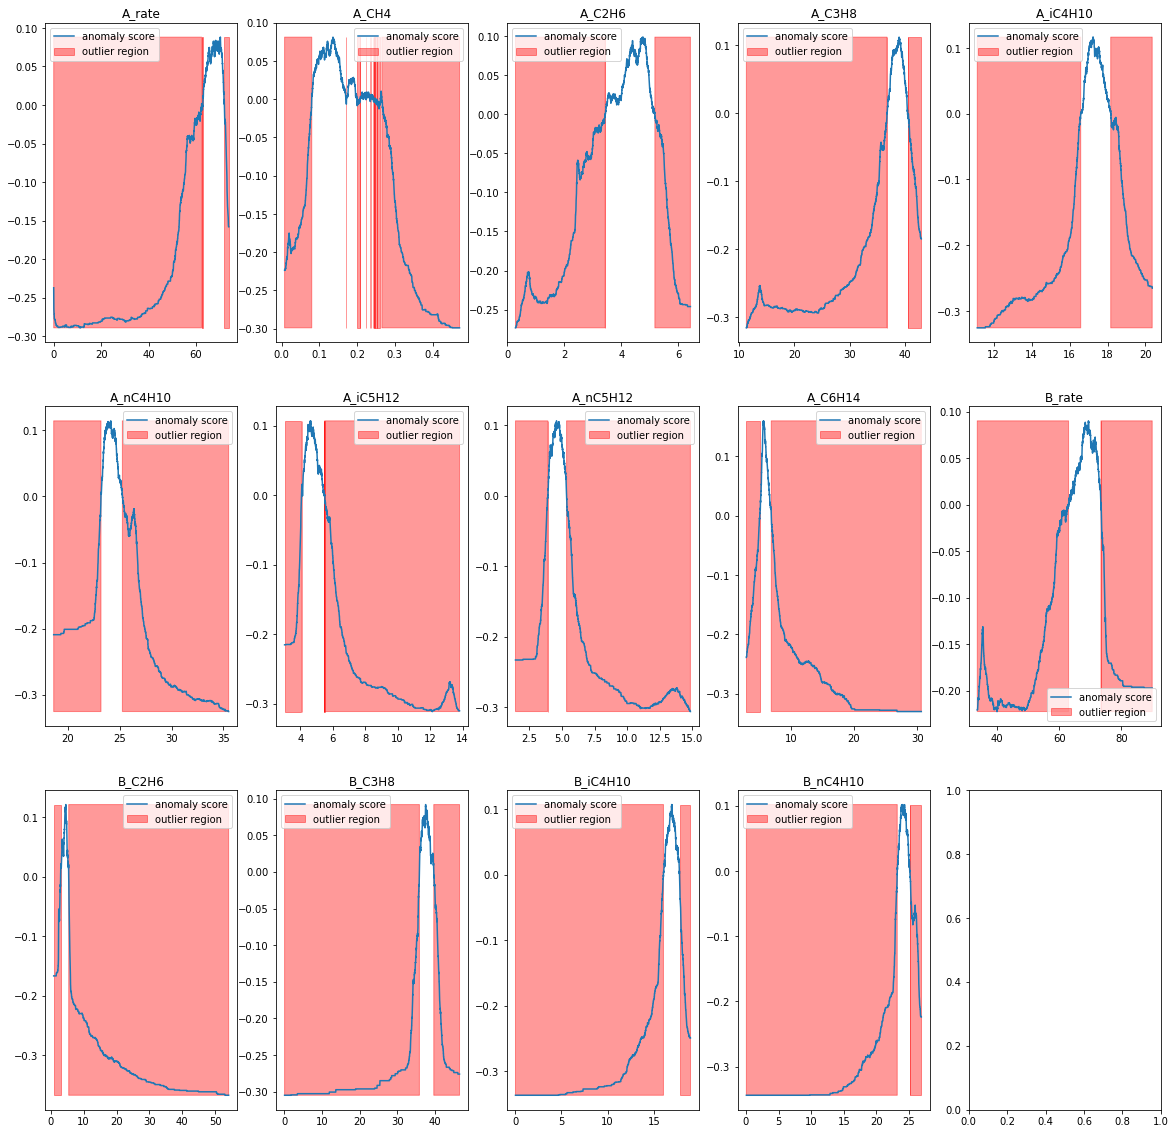

In [64]:
cols = ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10']
#Plotting the sub plot
fig, axs = plt.subplots(3, 5, figsize=(20, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df_combined_shifted[column].values.reshape(-1,1))

    xx = np.linspace(df_combined_shifted[column].min(), df_combined_shifted[column].max(), len(df_combined_shifted)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [65]:
df_combined_shifted.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'total_out_share'],
      dtype='object')

In [66]:
for c in ['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
          'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']:
    std=df_combined_shifted[c].std()
    mean=df_combined_shifted[c].mean()
    median=df_combined_shifted[c].median()
    df_combined_shifted[c][df_combined_shifted[c]>mean+1.45*std]=median
    df_combined_shifted[c][df_combined_shifted[c]<mean-1.45*std]=median
#     df_combined_shifted[c][df_combined_shifted[c]>mean+2*std]=median+1*std
#     df_combined_shifted[c][df_combined_shifted[c]<mean-2*std]=median-1*std


for c in ['B_C2H6',
          'B_C3H8', 'B_iC4H10', 'B_nC4H10']:
    std=df_combined_shifted[c].std()
    mean=df_combined_shifted[c].mean()
    median=df_combined_shifted[c].median()
    df_combined_shifted[c][df_combined_shifted[c]>mean+1.45*std]=median
    df_combined_shifted[c][df_combined_shifted[c]<mean-1.45*std]=median
#     df_combined_shifted[c][df_combined_shifted[c]>mean+2*std]=median+1*std
#     df_combined_shifted[c][df_combined_shifted[c]<mean-2*std]=median-1*std

<ipython-input-66-7719b2eac42a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_shifted[c][df_combined_shifted[c]<mean-1.45*std]=median
<ipython-input-66-7719b2eac42a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_shifted[c][df_combined_shifted[c]<mean-1.45*std]=median
<ipython-input-66-7719b2eac42a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_shifted[c][df_combined_shifted[c]<mean-1.45*std]

In [67]:
df_combined_shifted['A_rate'].std()

4.3397814359423625

Начинаем подбирать параметры нашего леса

In [68]:
X=df_combined_shifted[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10','A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']]
y=df_combined_shifted['B_C3H8']

In [69]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [71]:
# xgb1 = xg.XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], #so called `eta` value
#               'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#               'min_child_weight': [4, 5, 6, 7],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 5,
#                         verbose=True)

In [72]:
# # Код для подбора параметров
# params=[]
# for c in ['B_C3H8']:
#     y=df_combined_shifted[c]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#     xgb_grid.fit(X_train, y_train)
#     params.append([c, xgb_grid.best_score_, xgb_grid.best_params_])

In [73]:
# Код для подбора параметров
# params=[]
# for c in ['B_C2H6','B_C3H8', 'B_iC4H10', 'B_nC4H10']:
#     y=df_combined_shifted[c]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#     xgb_grid.fit(X_train, y_train)
#     params.append([c, xgb_grid.best_score_, xgb_grid.best_params_])

In [74]:
params

{'min_child_weight': [1, 5, 10],
 'gamma': [0.5, 1, 1.5, 2, 5],
 'subsample': [0.6, 0.8, 1.0],
 'colsample_bytree': [0.6, 0.8, 1.0],
 'max_depth': [3, 4, 5]}

In [75]:
df_combined_shifted.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'total_out_share'],
      dtype='object')

In [76]:
y=df_combined_shifted['B_C3H8']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [77]:
# xgb_grid.fit(X_train,
#          y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [78]:
xgb=xg.XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.03, 
                    max_depth= 14, 
                    min_child_weight= 5, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:pseudohubererror', 
                    silent= 1, 
                    subsample= 0.7)

In [79]:
xgb.fit(X_train, y_train)

[16:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=14,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:pseudohubererror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
y_pr=xgb.predict(X_test)

In [81]:
y_pr

array([1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145, 1.7361145,
       1.7361145, 1.7361145, 1.7361145, 1.7361145, 

In [82]:
y_test=np.array(y_test)

In [83]:
mape_score(y_test, y_pr)

0.9538903559808904

In [84]:
df_test=pd.read_csv(r'data/test_features.csv')

In [85]:
df_test

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447
...,...,...,...,...,...,...,...,...,...,...,...
3979,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026
3980,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451
3981,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878
3982,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867


In [86]:
df_combined.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'total_out_share'],
      dtype='object')

In [87]:
empty_index=get_index_empty_intervals(df_combined, columns=['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'])

In [88]:
empty_index

{'A_rate': [[1251, 1251]],
 'A_CH4': [[0, 8],
  [60, 60],
  [73, 85],
  [120, 135],
  [365, 365],
  [367, 367],
  [581, 600],
  [792, 796],
  [843, 843],
  [845, 859],
  [931, 932],
  [1200, 1235],
  [1237, 1272],
  [1274, 1374],
  [1376, 1497],
  [1499, 1573],
  [1575, 1697],
  [1699, 1708],
  [1711, 1716],
  [1742, 1743],
  [1749, 1770],
  [2111, 2134],
  [2481, 2481],
  [2483, 2483],
  [2644, 2656],
  [3200, 3204],
  [3224, 3236],
  [3619, 3652],
  [3707, 3707],
  [3958, 3968],
  [4203, 4203],
  [4213, 4244],
  [4439, 4439],
  [4523, 4556],
  [4561, 4561],
  [4716, 4749],
  [4799, 4842],
  [4911, 4911],
  [4913, 4917],
  [4967, 4973],
  [5159, 5159],
  [5161, 5194],
  [5669, 5669],
  [5671, 5680],
  [5747, 5779]],
 'A_C2H6': [[0, 8],
  [60, 60],
  [73, 85],
  [120, 135],
  [365, 365],
  [367, 367],
  [581, 600],
  [792, 796],
  [843, 843],
  [845, 859],
  [931, 932],
  [1200, 1235],
  [1237, 1272],
  [1274, 1374],
  [1376, 1497],
  [1499, 1573],
  [1575, 1697],
  [1699, 1708],
  [17

In [89]:
model = ExponentialSmoothing(df_combined.loc[:1273,'A_rate'].to_list())
model_fit = model.fit()
yt=model_fit.predict(1274, 1374)

D:\ProgramData\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [90]:
yt

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [91]:
df_combined.loc[:72,'A_rate'].to_list()

[70.85501687242801,
 70.82658197530856,
 70.80963734567905,
 69.99474823045267,
 70.0727618106996,
 69.99838096707822,
 69.92934125514402,
 70.28620769547318,
 70.52113314814814,
 71.05579234636295,
 71.02988119341559,
 71.00888446502059,
 71.060108909465,
 71.06786460905353,
 70.98086561728394,
 70.97414154320991,
 70.07925082304523,
 70.0429566255144,
 70.25891633744857,
 70.55813676954737,
 70.80728763374472,
 71.10763051440327,
 71.27609841563778,
 71.40969191358022,
 71.45779549382712,
 57.34147699588476,
 58.52521950617283,
 67.5545973045268,
 70.12139681069961,
 70.09119205761318,
 70.82545781892995,
 73.48257796296298,
 73.75033074074075,
 74.56039886831272,
 74.48345465020573,
 74.30724310699591,
 73.11438236625514,
 72.76481259259259,
 73.53108487654325,
 73.1607182304527,
 73.19564844733316,
 73.16854092592591,
 72.58669421810701,
 72.90756185185187,
 72.86012837448563,
 72.83832613168717,
 72.81948316872422,
 72.94717944444444,
 72.65578551440325,
 72.7596832921811,
 73.614

In [92]:
df_combined_all=df_combined.copy()

In [93]:
df_combined_all=df_combined_all.append(df_test, ignore_index=True)

In [94]:
df_combined_all.tail()

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10,total_out_share
9787,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026,NaN,NaN,NaN,NaN,NaN
9788,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451,NaN,NaN,NaN,NaN,NaN
9789,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878,NaN,NaN,NaN,NaN,NaN
9790,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867,NaN,NaN,NaN,NaN,NaN
9791,2020-07-22 23:30:00,72.941085,0.122393,4.207615,40.957330,17.772225,24.088445,4.387957,3.536302,4.863965,74.804667,NaN,NaN,NaN,NaN,NaN


In [95]:
df_combined_all.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'total_out_share'],
      dtype='object')

In [96]:
df_combined_all['A_rate']=df_combined_all['A_rate'].fillna(df_combined_all['B_rate'])

In [97]:
df_combined_all[['A_C2H6']] = df_combined_all[['A_C2H6']].shift(217)
df_combined_all[['A_CH4', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14']] = df_combined_all[['A_CH4', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14']].shift(217)

<AxesSubplot:>

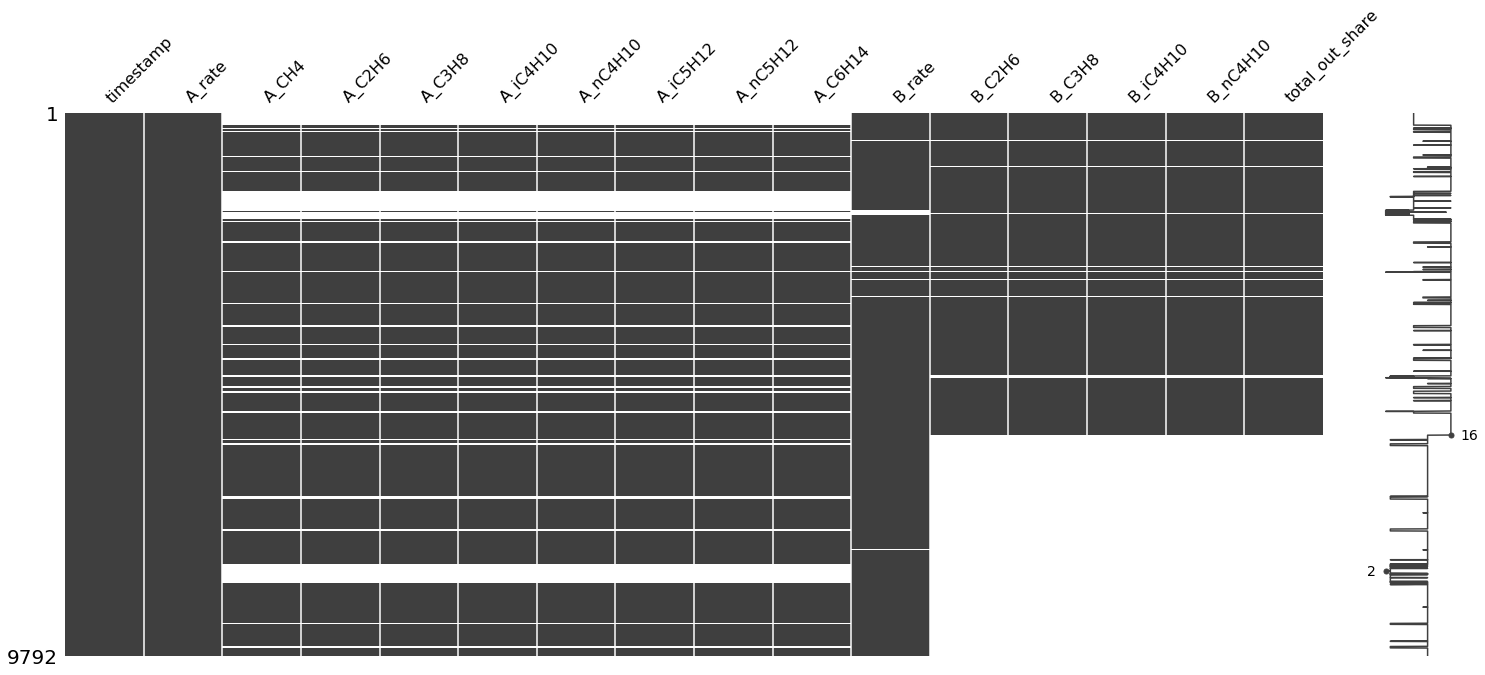

In [98]:
msno.matrix(df_combined_all)

<AxesSubplot:>

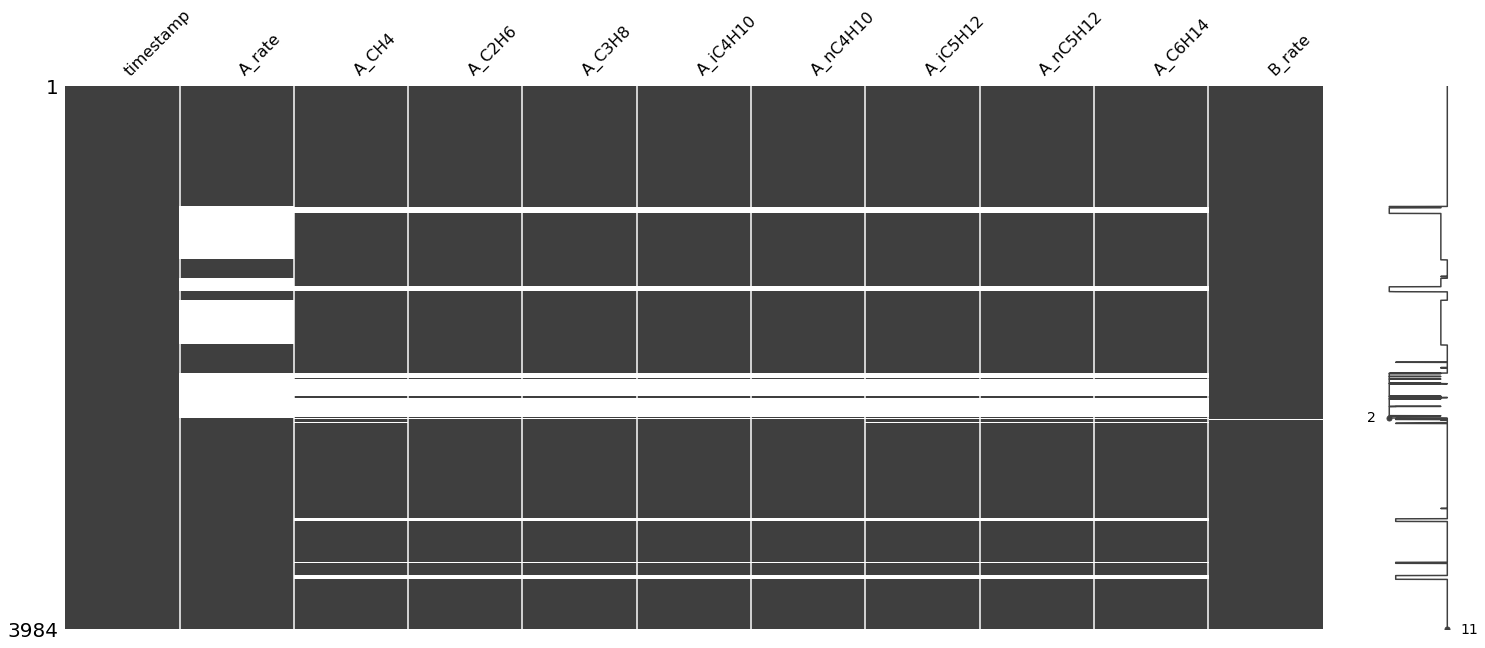

In [99]:
msno.matrix(df_test)

In [100]:
df_test.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate'],
      dtype='object')

In [101]:
df_combined_all['B_rate']=df_combined_all['B_rate'].fillna(df_combined_all['A_rate'])

<AxesSubplot:>

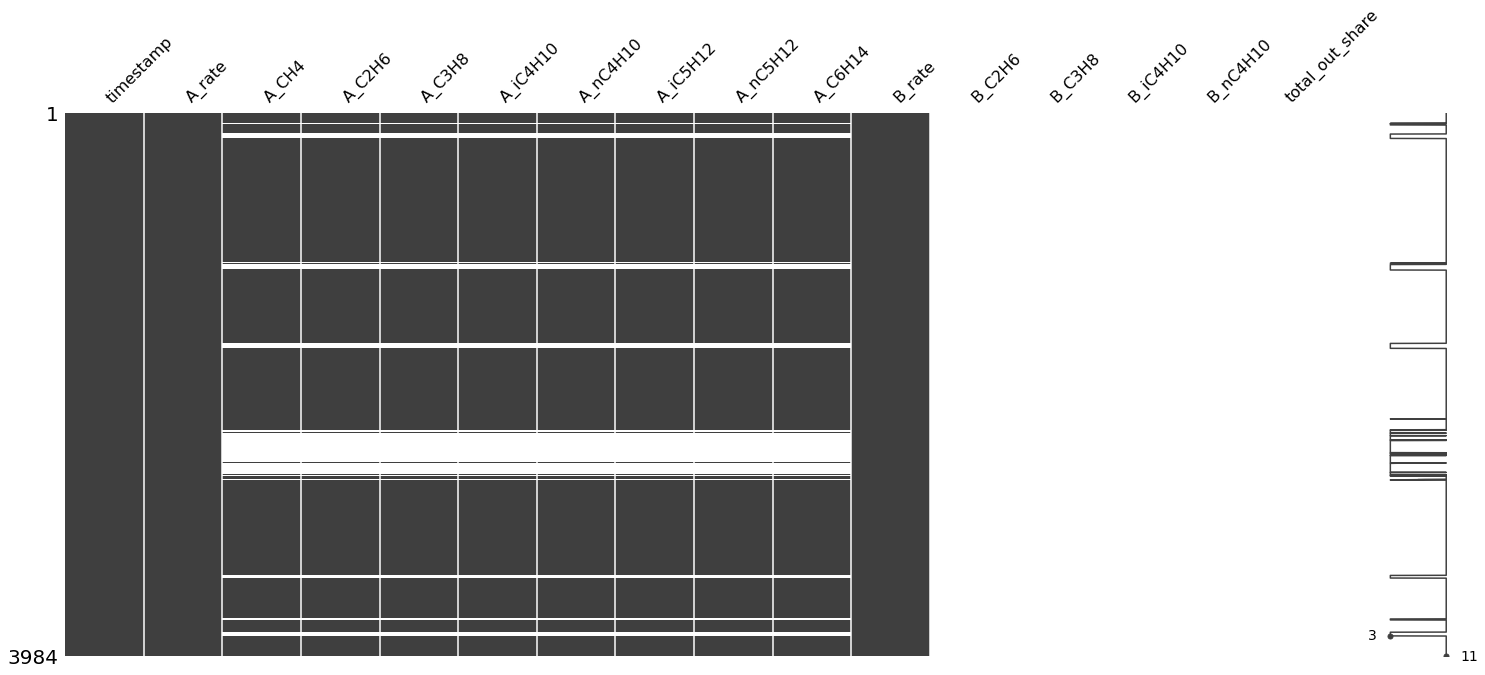

In [102]:
msno.matrix(df_combined_all[df_combined_all['timestamp']>='2020-05-01 00:00:00'])

In [103]:
df_combined_all=df_combined_all.loc[:,'A_rate':'B_rate'][df_combined_all['timestamp']>='2020-05-01 00:00:00'].reset_index(drop=True)

In [104]:
df_combined_shifted.columns

Index(['timestamp', 'A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10',
       'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate', 'B_C2H6',
       'B_C3H8', 'B_iC4H10', 'B_nC4H10', 'total_out_share'],
      dtype='object')

Начинаем прогноз

In [105]:
X=df_combined_shifted[['A_rate', 'A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10','A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14', 'B_rate']]
y=df_combined_shifted['B_C2H6']

In [106]:
xgb=xg.XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.05, 
                    max_depth= 14, 
                    min_child_weight= 4, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb.fit(X,y)

[16:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=14,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [107]:
result=df_test[['timestamp']]

In [108]:
result['B_C2H6']=xgb.predict(df_combined_all)

<ipython-input-108-56e2c6516a51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['B_C2H6']=xgb.predict(df_combined_all)


In [109]:
result

,timestamp,B_C2H6
0,2020-05-01 00:00:00,5.168332
1,2020-05-01 00:30:00,5.095984
2,2020-05-01 01:00:00,5.097801
3,2020-05-01 01:30:00,5.129764
4,2020-05-01 02:00:00,5.004384
...,...,...
3979,2020-07-22 21:30:00,4.572289
3980,2020-07-22 22:00:00,4.727648
3981,2020-07-22 22:30:00,4.690810
3982,2020-07-22 23:00:00,4.473149


In [110]:
y=df_combined_shifted['B_C3H8']

In [111]:
xgb=xg.XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.03, 
                    max_depth= 14, 
                    min_child_weight= 4, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb.fit(X,y)

[16:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=14,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, silent=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [112]:
result['B_C3H8']=xgb.predict(df_combined_all)

<ipython-input-112-f005c3cc7329>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['B_C3H8']=xgb.predict(df_combined_all)


In [113]:
y=df_combined_shifted['B_iC4H10']
xgb=xg.XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.07, 
                    max_depth= 12, 
                    min_child_weight= 7, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb.fit(X,y)
result['B_iC4H10']=xgb.predict(df_combined_all)

[16:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-113-3569bfd31721>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['B_iC4H10']=xgb.predict(df_combined_all)


In [114]:
y=df_combined_shifted['B_nC4H10']
xgb=xg.XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.03, 
                    max_depth= 14, 
                    min_child_weight= 5, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb.fit(X,y)
result['B_nC4H10']=xgb.predict(df_combined_all)

[16:20:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:20:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-114-7337e27e320d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['B_nC4H10']=xgb.predict(df_combined_all)


In [115]:
result=result[['timestamp','B_C2H6','B_C3H8','B_iC4H10','B_nC4H10']]

In [117]:
result.to_csv('submission.csv',index=False)

In [118]:
result.to_excel('submission.xlsx',index=False)

In [119]:
df_train_targets.describe()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
count,5624.000000,5628.000000,5628.000000,5628.000000
mean,4.363701,37.742757,16.843028,24.171264
std,2.931240,2.218569,1.059827,1.480740
min,0.861025,0.026142,0.012764,0.019941
25%,3.503610,36.827096,16.548084,23.736470
50%,4.395271,37.750088,16.934576,24.147675
75%,4.680156,38.730979,17.292647,24.642044
max,91.573613,61.931856,19.235807,27.184879


In [120]:
result.describe()

,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
count,3984.000000,3984.000000,3984.000000,3984.000000
mean,4.440416,37.702099,16.798368,24.010771
std,0.271276,0.639228,0.352947,0.187916
min,2.776066,36.013676,15.912054,23.418394
25%,4.248502,37.302775,16.515330,23.878462
50%,4.457339,37.800625,16.924661,23.992705
75%,4.621686,38.179859,17.049039,24.142357
max,5.357548,39.208664,17.583920,24.612906
